<hr style="color:green" />
<h1 style="color:green">COSC2673 Assignment 2: Image Classification for Cancerous Cells</h1>
<h2 style="color:green">File 31: Modelling on the Full data For the Cell Type Multiclass Classification</h2>
<hr style="color:green" />

<p>
After Reviewing files 22 - 28 we have experimented with improving the performance of the CNN with more complexity in the Convolutions and the Classifier layers. Taking into account performance increases but also processing time and complexity, the following model will be used here:
</p>
<ul>
<li>CNN, updated architecture without greyscale (from file 28)</li>
</ul>
<p>
Now, in an attempt to improve the performance of both the Binary and the Multiclass models, this process will make use of the full data, ie. both the Main Labels file and the Extras Label file. Because handling these two will be different, processing will be split into separate notebooks.
</p>

<ul>
<li>Binary IsCancerous: All data is labeled, so just add the new data to the dataset</li>
<li>Multiclass Cell Type (here): The data in the Extras file are unlabeled, so therefore, we will need to apply a Semi Supervised Learning approach</li>
</ul>
<p>
In this file, also load the Extra Label data as well as the main data. Then we will perform a Semi Supervised learning process. The basic premise of Semi Supervised learning will be  as follows
</p>

<ol>
<li>Train a baseline model using the labelled Main Data</li>
<li>Predict using this model on the unlabelled Extra Data, taking care to also retain the Softmax score for each value, which is a probability of being that label</li>
<li>Review these predictions, find any that have a high confidence (generally 80% probability is used)</li>
<li>Take this data, and apply that predicted label, called a "pseudo-label". Incorporate this pseudo-labeled data into the training data (also remove them from the extra data)</li>
<li>Train an updated model using the updated training data</li>
<li>Iterate the process from Step 2, until no high confidence data is generated, or capped at a number of rounds</li>
</ol>

In [49]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image

from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

Configure this script as to whether it runs on Google Colab, or locally

In [50]:
# When on Google Colab, running full training, change both to true. Locally, advised set both to false
isGoogleColab = False
useFullData = True

In [51]:
# In local, the base directory is the current directory
baseDirectory = "./"

if isGoogleColab:
    from google.colab import drive
    
    # If this is running on Google colab, assume the notebook runs in a "COSC2673" folder, which also contains the data files 
    # in a subfolder called "image_classification_data"
    drive.mount("/content/drive")
    !ls /content/drive/'My Drive'/COSC2673/

    # Import the directory so that custom python libraries can be imported
    import sys
    sys.path.append("/content/drive/MyDrive/COSC2673/")

    # Set the base directory to the Google Drive specific folder
    baseDirectory = "/content/drive/MyDrive/COSC2673/"

Import the custom python files that contain reusable code

In [52]:
# randomSeed = dbutil.get_random_seed()
randomSeed = 266305
print("Random Seed: " + str(randomSeed))

Random Seed: 266305


### Define helper functions

Finding the Mean and Standard Deviations for the training images, in order to do image normalization, is computationally very long. These have been precalculated according to the Train/Validation/Test Split in the images_main.csv file, so create a function here that returns the correct values as tensors.

Create Custom PyTorch Dataset classes for the Binary IsCancerous task and the Multi-class CellType task.

Create a reusable Function to generate an ROC Curve plot(s) that work for both binary classification results and multi-class classification results. Also Create a reusable function for plotting 2 series in a line plot.

In [ ]:
# Get the Mean and Standard Deviation for the Training images (precalculated in file 05a)
def getTrainMeanAndStdTensors():
    train_mean = torch.tensor([0.8035, 0.5909, 0.7640])
    train_std = torch.tensor([0.1246, 0.1947, 0.1714])
    return train_mean, train_std

# Custom DataSet class for loading the image dataset using PyTorch NNs for the isCancerous modelling
class CancerBinaryDataset(Dataset):
    def __init__(self, isGoogleColab, dfImages, img_dir, transform=None, target_transform=None): 
        # Store a flag on the deployment env
        self.is_google_colab = isGoogleColab
        # Keep a reference to the data set        
        self.df_images = dfImages
        # Set the labels to the the target column in the dataset
        self.img_labels = dfImages["isCancerous"]
        # Pass in the image directory and transform operation
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    # Get the length of the dataset from the length of the labels
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        # Load the image using the image directory and then from the ImageName col in the dataframe
        img_name = self.df_images.loc[idx, "ImageName"]
        img_name = img_name.replace("\\", "/")

        # if it's google colab, then strip out the leading "./"
        if self.is_google_colab:
            if img_name.startswith("./"):
                img_name = img_name[2:]            

        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path)

        # Set the label
        label = self.img_labels[idx]

        # Apply the transform
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        # Return the image and the label
        return image, label


# Custom DataSet class for loading the image dataset using PyTorch NNs for the CellType modelling
class CancerCellTypeDataset(Dataset):
    def __init__(self, isGoogleColab, dfImages, img_dir, transform=None, target_transform=None): 
        # Store a flag on the deployment env
        self.is_google_colab = isGoogleColab        
        # Keep a reference to the data set
        self.df_images = dfImages
        # Set the labels to the the target column in the dataset
        self.img_labels = dfImages["cellType"]
        # Pass in the image directory and transform operation
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    # Get the length of the dataset from the length of the labels
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        # Load the image using the image directory and then from the ImageName col in the dataframe
        img_name = self.df_images.loc[idx, "ImageName"]
        img_name = img_name.replace("\\", "/")

        # if it's google colab, then strip out the leading "./"
        if self.is_google_colab:
            if img_name.startswith("./"):
                img_name = img_name[2:]            

        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path)

        # Set the label
        label = self.img_labels[idx]

        # Apply the transform
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        # Return the image and the label
        return image, label    


def getClassificationROC(predictor_name, set_name, y_true, y_pred, num_classes=2, y_pred_scores=None):
    if num_classes <= 1:
        print("Error: Number of label classes must be 2 or more")
        return -1
    elif num_classes == 2:
        # Do a Binary Classification ROC Curve

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)

        plt.figure(1)
        plt.plot([0, 1], [0, 1])
        plt.plot(fpr, tpr, label="CNN(area = {:.3f})".format(roc_auc))
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.title(predictor_name + " " + set_name + " Set ROC curve")
        plt.legend(loc="best")
        plt.show()

        print("ROC (Area): " + str(roc_auc))
        return roc_auc
    else:
        # Do a multi-class, which will show a ROC Curve for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        list_roc_auc = []
        
        # first binarize the labels (converting from a number to a list of booleans)        
        y_true_bin = label_binarize(y_true, classes=range(num_classes))
        
        # Loop through each class, Compute ROC curve and ROC area for each class
        for i in range(num_classes):
            # Get a list of the scores for this class
            list_scores = []
            for j in range(len(y_pred_scores)):
                list_scores.append(y_pred_scores[j][i])
                
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], list_scores)
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot of a ROC curve for a specific class
        for i in range(num_classes):
            plt.figure()
            plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(predictor_name + " " + set_name + " Set ROC for class number " + str(i))
            plt.legend(loc="lower right")
            plt.show()  

            list_roc_auc.append(roc_auc[i])

        # Average the area under curve for each, print and return
        roc_auc_mean = np.mean(list_roc_auc)     
        print("Mean ROC (Area): " + str(roc_auc_mean))     
        return roc_auc_mean


# Basic Line Graph with two series. Specify a single X feature and then two features to plot as two lines
def graphBasicTwoSeries(dfInput, xCol, series1Col, series2Col, title, xLabel, series1Label, series2Label, useMarkers=False, showLegend=True):
    plt.title(title)
    xaxis = dfInput[xCol]
    series1 = dfInput[series1Col]
    series2 = dfInput[series2Col]

    plt.xlabel(xLabel)
    marker1 = ''
    marker2 = ''
    if useMarkers:
        marker1 = '.'
        marker2 = 'x'

    plt.plot(xaxis, series1, c='#0000FF', marker=marker1, markersize=8, label=series1Label) 
    plt.plot(xaxis, series2, c='#FF0000', marker=marker2, markersize=8, label=series2Label) 

    if showLegend:
        plt.legend()

    return plt 

In [53]:
# this file should have previously been created in the root directory
dfImages = pd.read_csv(baseDirectory + "images_main.csv")
dfImagesExtra = pd.read_csv(baseDirectory + "images_extra.csv")

In [54]:
# Get The training Split and the Validation Split
dfImagesTrain = dfImages[dfImages["trainValTest"] == 0].reset_index()
dfImagesVal = dfImages[dfImages["trainValTest"] == 1].reset_index()
dfImagesTest = dfImages[dfImages["trainValTest"] == 2].reset_index()

print(dfImagesTrain.shape)
print(dfImagesVal.shape)
print(dfImagesTest.shape)

dfImagesTrain.head()

(7837, 5)
(1031, 5)
(1028, 5)


,index,ImageName,isCancerous,cellType,trainValTest
0,0,./Image_classification_data/patch_images\1.png,0,0,0
1,1,./Image_classification_data/patch_images\10.png,0,0,0
2,3,./Image_classification_data/patch_images\1000.png,1,2,0
3,4,./Image_classification_data/patch_images\10000...,0,1,0
4,5,./Image_classification_data/patch_images\10001...,0,1,0


In the Semi Supervised Learning, there is no point in Splitting the Extra data into the flagged Train/Validation/Test Split, as it's unlabelled by Cell Type. Therefore, all extra data will be used as part of the SS Training process

Note: The definition of the Custom Datasets for both the isCancerous data and the Cell Type data are defined in the pytorch_utility.py file.

Also, rather than loading all the training images and calculating the mean and standard deviation values in here, that was run separately in file 05a.PyTorchGetMeanAndStd.ipynb

Here we can just define the values to use, which shouldn't change unless the data is reloaded and a new train/validation/test split is generated

In [55]:
train_mean, train_std = getTrainMeanAndStdTensors()
print(train_mean)
print(train_std)

tensor([0.8035, 0.5909, 0.7640])
tensor([0.1246, 0.1947, 0.1714])


In [56]:
# Create a tranform operation that also normalizes the images according to the mean and standard deviations of the images
transform_normalize = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.ToTensor(), 
    transforms.Normalize(train_mean, train_std)])


# Semi Supervised Learning

Initially, only create data loaders for the validation data and the test data, as these sets will not change. 

In [57]:
celltype_validation_data = CancerCellTypeDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize)
celltype_test_data = CancerCellTypeDataset(isGoogleColab, dfImagesTest, baseDirectory, transform=transform_normalize)

# Create data loaders
celltype_val_dataloader = DataLoader(celltype_validation_data, batch_size=32, shuffle=True, num_workers=2)
celltype_test_dataloader = DataLoader(celltype_test_data, batch_size=32, shuffle=True, num_workers=2)

Define the classe for the CNN. At the moment, we are using the the standard CNN structure with Early stopping (File 22)

In [58]:
# Create a class for the Neural Network
class PT_CNN_CellType(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_CNN_CellType, self).__init__()


        # first, define the subsampling methods. Though they are used multiple times, these are the
        # operations, so only need to be defined once
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        # define the Activation methods to use
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)

        # define the convolution layers

        # input should be 27x27x1. Apply a 5x5 filter, therefore, output should be 23x23x64 (channels aka feature maps)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1)
        # There will be a Relu
        # Then a MaxPool of 2x2, halving the dimensions per feature map
        # So input is 11x11x32. Apply a 3x3 filter, also include padding=1, as this is already quite small, and lets consider the edges
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)    
        # There will be a Relu    
        # Then a MaxPool of 2x2, halving the dimensions per feature map    
        # So input is 5x5x64. Apply a 3x3 filter
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        # Then a MaxPool of 2x2, halving the dimensions per feature map
        # Final output is 2x2
        
        # define the fully connected neural layers
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 4)

    # Create the forward function, which is used in training
    def forward(self, x):

        # print("Init Shape: " + str(x.shape))
        # print("  Shape 1: " + str(x.shape))

        # Process the first 2 convolution layers, applying maxpooling
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        # Then process the remaining convolution layers without any pooling
        x = self.relu(self.conv2(x))     
        x = self.maxpool(x)  
        x = self.relu(self.conv3(x))

        # Then apply a max pool and average pool on the result
        x = self.maxpool(x)
        #x = self.avgpool(x)

        # Flatten: This should convert to tensors that are acceptable for the input into the NN 3 layers
        x = x.view(x.size(0), 256 * 2 * 2)

        # Now process the 3 layers of the Fully Connected NN
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))      
        # x = self.fc3(x)
        # x = self.relu(self.fc3(x))
        x = F.softmax(self.fc3(x), dim=1)        

        # return the result
        return x



Create a function to Predict using a particular mode and return results

In [59]:
def predictCellTypeOnDataSetAccuracy(net, setName, dataloader, printResult=True, printFullResults=False):
    correct, total = 0,  0
    predictions = []

    y_celltype = []
    y_pred_celltype = []
    y_pred_celltype_scores = []

    # Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Loop through the batch, build the lists of the raw label and prediction values
        for j in range(len(labels)):
            y_celltype.append(labels[j].item())
            y_pred_celltype.append(predicted[j].item())
            y_pred_celltype_scores.append(outputs.data[j].tolist())

        predictions.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = accuracy_score(y_celltype, y_pred_celltype)
    f1Score = f1_score(y_celltype, y_pred_celltype, average="micro")

    if printFullResults:
        print(setName + ":")        
        print('Confusion matrix: \n')
        print(confusion_matrix(y_celltype, y_pred_celltype))
        print("\n- Accuracy Score: " + str(accuracy))
        print("- Precision Score: " + str(precision_score(y_celltype, y_pred_celltype, average="micro")))
        print("- Recall Score: " + str(recall_score(y_celltype, y_pred_celltype, average="micro")))
        print("- F1 Score: " + str(f1Score))
    elif printResult:
        print("- " + setName + " F1: " + str(f1Score))

    return accuracy, y_celltype, y_pred_celltype, y_pred_celltype_scores

Set some standard learning variables that will be used across all iterations

In [60]:
# set the Learning Rate to use
learning_rate = 0.0001
maxEpochs = 40
patience = 2
disableEarlyStopping = False

if useFullData == False:
    maxEpochs = 5
    patience = 1

Create a Function, that given a PyTorch dataload with a set of data to train in, train a CNN model

In [61]:
def train_celltype_model(iteration, celltype_train_dataloader):
    # Define CNN with the loss and the optimizer
    net = PT_CNN_CellType()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    bestErrorDiff = 99999
    concurrentNonImproves = 0
    currentEpoch = 0

    bestValAcc = -1
    lstEpochs = []
    lstTrainAccs = []
    lstValAccs = []
    for epoch in range(maxEpochs):
        print("Starting Epoch " + str(epoch) + "...")
        currentEpoch = epoch

        # Set the Neural Network into training mode
        net.train()

        # Train through this epoch
        for i, data in enumerate(celltype_train_dataloader, 0):
            # Get the inputs
            inputs, labels = data

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Perform Forward and Backward propagation then optimize the weights
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Set the Neural Network into evaluation (test) mode, so we can evaluate both training and validation error
        net.eval()        
        trainingAccuracy, y_train_celltype, y_train_pred_celltype, y_train_pred_celltype_scores = predictCellTypeOnDataSetAccuracy(
            net, "Training", celltype_train_dataloader, True, False)
        validationAccuracy, y_val_celltype, y_val_pred_celltype, y_val_pred_celltype_scores  = predictCellTypeOnDataSetAccuracy(
            net, "Validation", celltype_val_dataloader, True, False)

        errorDiff = trainingAccuracy - validationAccuracy
        print("- Accuracy Difference: " + str(errorDiff))

        lstEpochs.append(epoch)
        lstTrainAccs.append(trainingAccuracy)
        lstValAccs.append(validationAccuracy)

        if epoch > 0 and (validationAccuracy - bestValAcc > 0.01):        
            # There is at least percentage point improvement in the validation F1, count this as a 
            # good iteration, regardless of the error difference
            print("- IsGoodStep")
            concurrentNonImproves = 0
            if errorDiff > 0 and errorDiff < bestErrorDiff:  
                bestErrorDiff = errorDiff        
        elif errorDiff < bestErrorDiff:        
            # This epoch is an improvement on the last, so we will continue. the concurrent non improve counts reset for the patience
            print("- IsBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
            concurrentNonImproves = 0
            if errorDiff > 0:
                bestErrorDiff = errorDiff
        else:
            # This epoch has the same or worse performance than the last. Check if we have reached the patience, if so, then stop early
            print("- IsNotBetter: " + str(errorDiff) + " : " + str(bestErrorDiff))        
            concurrentNonImproves += 1
            if disableEarlyStopping == False:
                if concurrentNonImproves >= patience:
                    print("Early Stopping occurred at Epoch " + str(epoch))
                    break

        # update the val F1 score from the previous epoch if it's the best
        if validationAccuracy > bestValAcc:
            bestValAcc = validationAccuracy

    # Create a dataframe that can be used to plot the Training/Validation Loss plot, if we want to use it later
    dfLoss = pd.DataFrame({ 'epoch': lstEpochs, 'train': lstTrainAccs, 'validation': lstValAccs })

    # Once this is done, return the new CNN model and the loss dataframe
    return net, dfLoss


Now, load the initial training data into the celltype_training_data then configure it as a PyTorch Dataloader. This will be for our baseline model

Also, initialize a dataloader for the extra data

In [62]:
celltype_training_data = None

# Create copies of the Train and Extra images dataset, these will be continually updated through SS
dfImagesTrainSS = dfImagesTrain
dfExtraSS = dfImagesExtra

# Create a an initial dataloader for both train and extra images
if useFullData:
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrainSS, baseDirectory, transform=transform_normalize)
    celltype_extra_data = CancerCellTypeDataset(isGoogleColab, dfExtraSS, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainSS = dfImagesTrainSS.iloc[range(500), :].reset_index()
    dfExtraSS = dfExtraSS.iloc[range(500), :].reset_index()
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrainSS, baseDirectory, transform=transform_normalize, target_transform=None)
    celltype_extra_data = CancerCellTypeDataset(isGoogleColab, dfExtraSS, baseDirectory, transform=transform_normalize, target_transform=None)

    
celltype_train_dataloader = DataLoader(celltype_training_data, batch_size=32, shuffle=True, num_workers=2)
celltype_extra_dataloader = DataLoader(celltype_extra_data, batch_size=32, shuffle=True, num_workers=2)

### Semi-supervised Loop

Here we will implement the Semi-supervised Learning Loop. This is the high level process:

<ol>
<li>Train a baseline model using the labelled Main Data</li>
<li>Predict using this model on the unlabelled Extra Data, taking care to also retain the Softmax score for each value, which is a probability of being that label</li>
<li>Review these predictions, find any that have a high confidence (generally 80% probability is used)</li>
<li>Take this data, and apply that predicted label, called a "pseudo-label". Incorporate this pseudo-labeled data into the training data (also remove them from the extra data)</li>
<li>Train an updated model using the updated training data</li>
<li>Iterate the process from Step 2, until no high confidence data is generated, or capped at a number of rounds</li>
</ol>

In [63]:
maxIterations = 5
currentIteration = 0
highConfThreshold = 0.9
noMorePseudos = False
extraDataStop = False

In [64]:
previousNet = None
previousValAccuracy = -1

while (currentIteration < maxIterations) and noMorePseudos == False:    
    # Using the current training dataloader, train a model
    print("\nSemi-Supervised Iteration " + str(currentIteration))
    net, dfLoss = train_celltype_model(currentIteration, celltype_train_dataloader)

    # If the extra data was emptied in the previous iteration, we still want to train the model with all the extra data added.
    # But stop here, no need to predict on the (empty) extra data and keep going
    if extraDataStop:        
        print("   Stop SS Cycle - No or Insignficant remaining Extra Data.")
        noMorePseudos = True    
        break

    # Predict using the model on all the extra data. Ensure to get the predicted labels and the softmax probability score
    extraAcc, y_extra_celltype, y_extra_pred_celltype, y_extra_pred_celltype_scores = predictCellTypeOnDataSetAccuracy(
        net, "Extra", celltype_extra_dataloader, True, False)

    # From the list of scores (1 for each class per prediction), get the score for the predicted class
    pred_scores = []
    for i in range(len(y_extra_pred_celltype_scores)):
        # The predicted label will give the index of the related score
        ind = y_extra_pred_celltype[i]
        pred_scores.append(y_extra_pred_celltype_scores[i][ind])

    # Append the predictions and scores to the extra data
    dfExtraPred = dfExtraSS
    dfExtraPred["PredCellType"] = y_extra_pred_celltype    
    dfExtraPred["PredScore"] = pred_scores

    # Get all the predictions that exceed the high confidence threshold. If there are none, set noMorePseudos = True then break the loop
    dfHighConf = dfExtraPred[dfExtraPred["PredScore"] >= highConfThreshold]
    print("   Number of High Conf Predictions: " + str(dfHighConf.shape[0]))
    if dfHighConf.shape[0] == 0:        
        print("   Stop SS Cycle - No High Confidence Predictions.")
        noMorePseudos = True
        break    
    elif dfHighConf.shape[0] <= 20:        
        print("   Stop SS Cycle - Insignificant number of High Conf Predictions (" + str(dfHighConf.shape[0]) + ").")
        noMorePseudos = True
        break    
    else:
        # For the high Confidence records, treat the Predicted score as the pseudolabel, overwriting the cell type (which is -1)
        dfHighConf.loc[:, "cellType"] = dfHighConf.loc[:, "PredCellType"]

        # Add the high conf records to the training data
        dfHighConf = dfHighConf.drop(["PredCellType", "PredScore"], axis=1)
        dfImagesTrainSS = pd.concat([dfImagesTrainSS, dfHighConf], axis=0).reset_index(drop=True)

        # Filter out the high conf records from the extra dataset
        dfExtraSS = dfExtraPred[dfExtraPred["PredScore"] < highConfThreshold].reset_index(drop=True)
        dfExtraSS = dfExtraSS.drop(["PredCellType", "PredScore"], axis=1)

        print("   Updated Train Images Shape: " + str(dfImagesTrainSS.shape))
        print("   Updated Extra Images Shape: " + str(dfExtraSS.shape))
        
        # Update the Data loaders with the updated training and extra sets      
        celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrainSS, baseDirectory, transform=transform_normalize)
        celltype_train_dataloader = DataLoader(celltype_training_data, batch_size=32, shuffle=True, num_workers=2)   


        if dfExtraSS.shape[0] > 20:
            # There is still more data in the extra data, setup the data loader
            celltype_extra_data = CancerCellTypeDataset(isGoogleColab, dfExtraSS, baseDirectory, transform=transform_normalize) 
            celltype_extra_dataloader = DataLoader(celltype_extra_data, batch_size=32, shuffle=True, num_workers=2)    
        else:       
            extraDataEmpty = True        

        currentIteration += 1

    # Predict on the Validation Set to get an Accuracy
    valAcc, y_val_celltype, y_val_pred_celltype, y_val_pred_celltype_scores = predictCellTypeOnDataSetAccuracy(
        net, "Validation", celltype_val_dataloader, True, False)        

    if valAcc < previousValAccuracy:
        # This iteration has not improved in accuracy. Discard it, use the last model and end the iterations
        print("   Stop SS Cycle - Validation Accuracy has not improved.")
        print("      Previous Validation Accuracy: " + str(previousValAccuracy))        
        net = previousNet
        noMorePseudos = True
    else:
        # Save the net and accuracy as the previous before the next iteration starts
        previousValAccuracy = valAcc
        previousNet = net

    


Semi-Supervised Iteration 0
Starting Epoch 0...
- Training F1: 0.6827867806558632
- Validation F1: 0.7720659553831232
- Accuracy Difference: -0.08927917472725999
- IsBetter: -0.08927917472725999 : 99999
Starting Epoch 1...
- Training F1: 0.7006507592190889
- Validation F1: 0.7895247332686712
- Accuracy Difference: -0.0888739740495823
- IsGoodStep
Starting Epoch 2...
- Training F1: 0.7385479137425035
- Validation F1: 0.7536372453928225
- Accuracy Difference: -0.015089331650319004
- IsBetter: -0.015089331650319004 : 99999
Starting Epoch 3...
- Training F1: 0.7398239122113054
- Validation F1: 0.7837051406401551
- Accuracy Difference: -0.04388122842884978
- IsBetter: -0.04388122842884978 : 99999
Starting Epoch 4...
- Training F1: 0.7306367232359321
- Validation F1: 0.7817652764306497
- Accuracy Difference: -0.05112855319471776
- IsBetter: -0.05112855319471776 : 99999
Starting Epoch 5...
- Training F1: 0.7002679596784483
- Validation F1: 0.7759456838021338
- Accuracy Difference: -0.0756777

c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


- Validation F1: 0.7769156159068865

Semi-Supervised Iteration 1
Starting Epoch 0...
- Training F1: 0.5820649183935448
- Validation F1: 0.7148399612027158
- Accuracy Difference: -0.13277504280917096
- IsBetter: -0.13277504280917096 : 99999
Starting Epoch 1...
- Training F1: 0.6189253621859527
- Validation F1: 0.7429679922405431
- Accuracy Difference: -0.12404263005459037
- IsGoodStep
Starting Epoch 2...
- Training F1: 0.6317623326609206
- Validation F1: 0.7778855480116392
- Accuracy Difference: -0.1461232153507186
- IsGoodStep
Starting Epoch 3...
- Training F1: 0.6380585610367382
- Validation F1: 0.7652764306498545
- Accuracy Difference: -0.12721786961311632
- IsBetter: -0.12721786961311632 : 99999
Starting Epoch 4...
- Training F1: 0.6463720276300507
- Validation F1: 0.7575169738118331
- Accuracy Difference: -0.11114494618178239
- IsBetter: -0.11114494618178239 : 99999
Starting Epoch 5...
- Training F1: 0.6523626138517025
- Validation F1: 0.7701260911736177
- Accuracy Difference: -0.1

c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


- Validation F1: 0.7449078564500486
   Stop SS Cycle - Validation Accuracy has not improved.
      Previous Validation Accuracy: 0.7769156159068865


In [65]:
# dfLoss = pd.DataFrame({ 'epoch': lstEpochs, 'train': lstTrainAccs, 'validation': lstValAccs })
# graphutil.graphBasicTwoSeries(dfLoss, "epoch", "train", "validation", "CellType Training and Validation Accuracy", 
#         "Epoch", "Training Accuracy", "Validation Accuracy")

Predict on the Training Set to get the Training Accuracy and Error

In [66]:
trainingAcc, y_train_celltype, y_train_pred_celltype, y_train_pred_celltype_scores = predictCellTypeOnDataSetAccuracy(
    net, "Training", celltype_train_dataloader, True, True)

Training:
Confusion matrix: 

[[1408  455  773  165]
 [ 485 2614 1433   92]
 [1223 1924 6167   38]
 [ 162  338  115  631]]

- Accuracy Score: 0.6003440048826499
- Precision Score: 0.6003440048826499
- Recall Score: 0.6003440048826499
- F1 Score: 0.6003440048826499


In [67]:
for i in range(5):
    print(y_train_pred_celltype_scores[i])

[2.4570244505639494e-08, 0.9999969005584717, 6.745987661815889e-07, 2.39449946093373e-06]
[1.7870161173050292e-05, 0.9972767233848572, 8.35155151435174e-06, 0.002697122748941183]
[2.0799272026916782e-10, 6.917923123239689e-09, 1.0, 8.672029193107934e-15]
[0.7258325815200806, 0.022055303677916527, 0.00017885158013086766, 0.2519332468509674]
[0.9018144607543945, 8.267455996247008e-06, 0.09817227721214294, 4.892101060249843e-06]


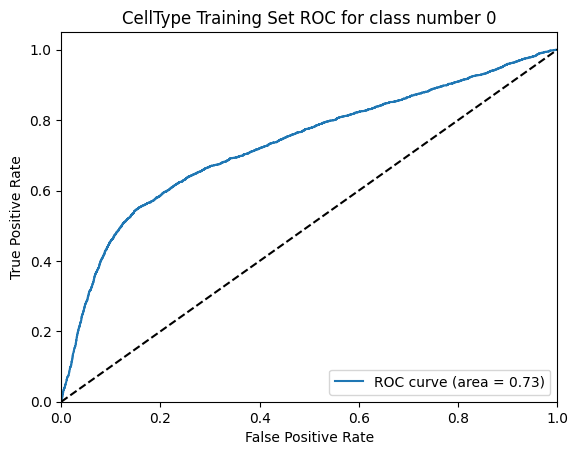

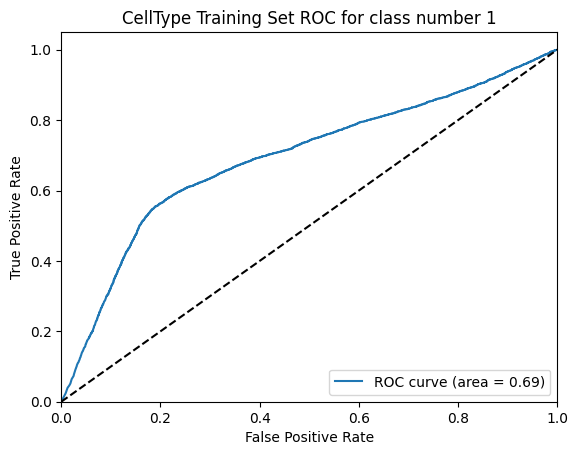

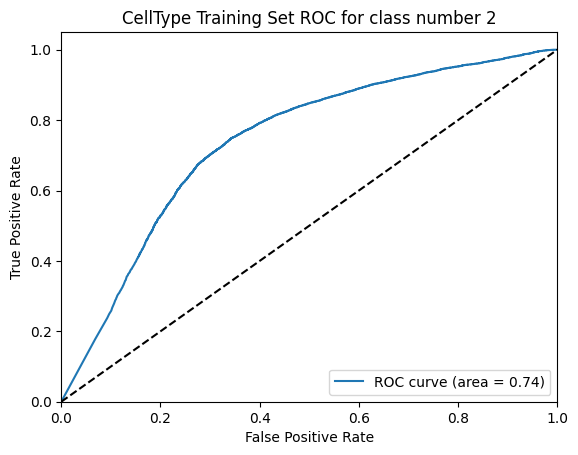

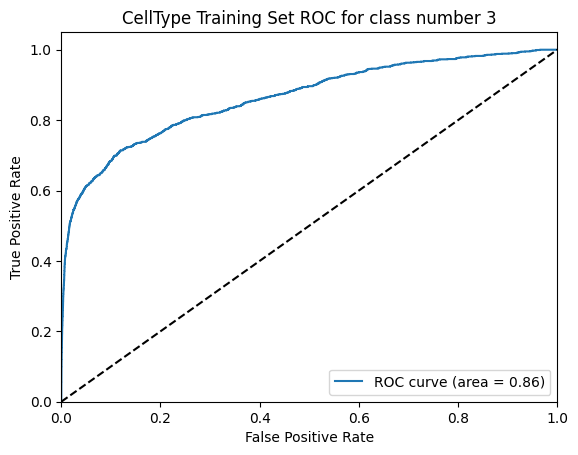

Mean ROC (Area): 0.7565826245237505


0.7565826245237505

In [68]:
getClassificationROC("CellType", "Training", y_train_celltype, y_train_pred_celltype, 4, y_train_pred_celltype_scores)

Predict on the Validation data and evaluate the results

In [69]:
testAccuracy, y_test_celltype, y_test_pred_celltype, y_test_pred_celltype_scores  = predictCellTypeOnDataSetAccuracy(
        net, "Test", celltype_test_dataloader, True, True)


Test:
Confusion matrix: 

[[ 98  17  17   8]
 [ 13 148  19   5]
 [ 26  30 567   0]
 [ 10  32  30   8]]

- Accuracy Score: 0.7986381322957199
- Precision Score: 0.7986381322957199
- Recall Score: 0.7986381322957199
- F1 Score: 0.7986381322957199


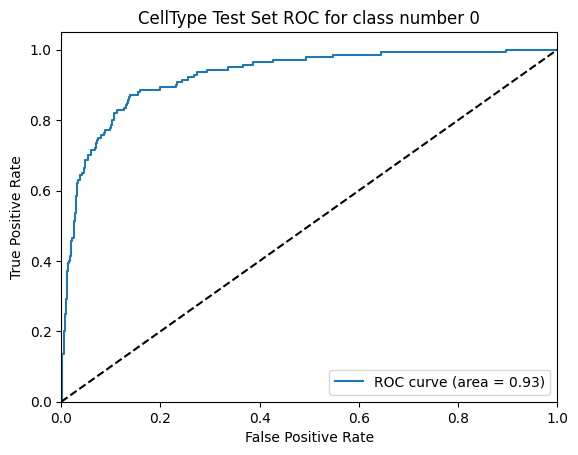

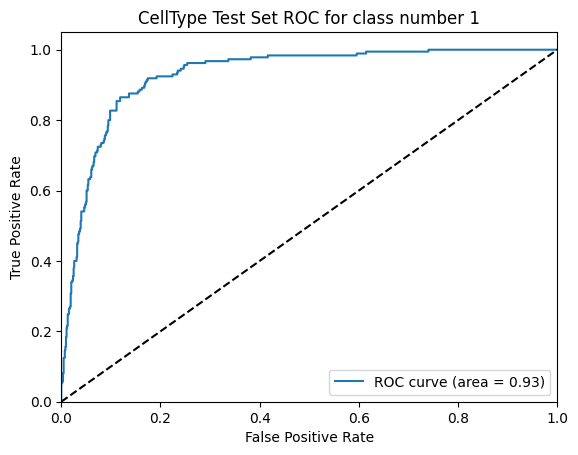

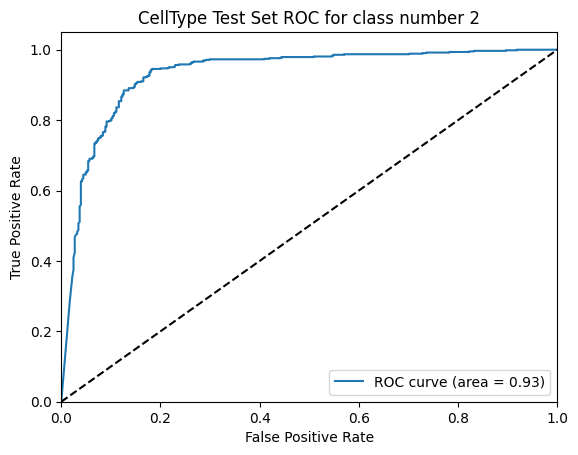

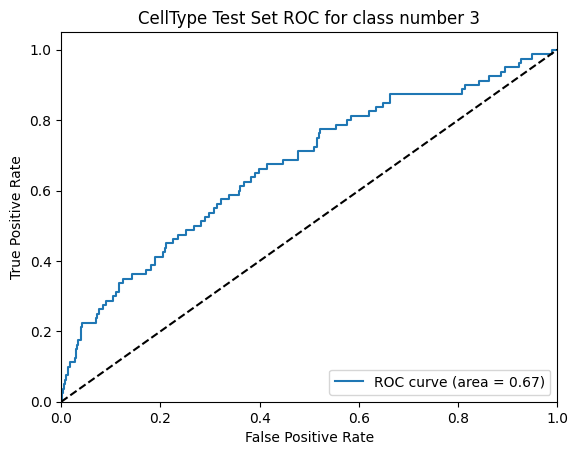

Mean ROC (Area): 0.8638146958009207


0.8638146958009207

In [70]:
getClassificationROC("CellType", "Test", y_test_celltype, y_test_pred_celltype, 4, y_test_pred_celltype_scores)

# Results

Append Results for both Binary IsCancerous and Cell Type here

### Cell Type Results

Best NN, 2 Layer in 05c:
- **Training**
- Accuracy Score: 0.8672961592446089
- Precision Score: 0.8672961592446089
- Recall Score: 0.8672961592446089
- F1 Score: 0.8672961592446089
- **Test**
- Accuracy Score: 0.7898832684824902
- Precision Score: 0.7898832684824902
- Recall Score: 0.7898832684824902
- F1 Score: 0.7898832684824902

Best CNN:
CNN07, updated CNN with without greyscale
- **Training**
- Accuracy Score: 0.8320786015056781
- Precision Score: 0.8320786015056781
- Recall Score: 0.8320786015056781
- F1 Score: 0.8320786015056783
- **Test**
- Accuracy Score: 0.796692607003891
- Precision Score: 0.796692607003891
- Recall Score: 0.796692607003891
- F1 Score: 0.796692607003891

This Result, Semi Supervised Learning with Best CNN, high conf threshold is 0.97, but still, most of the extra records were judged high conf in the first iteration?
- **Training**
- Accuracy Score: 0.6003440048826499
- Precision Score: 0.6003440048826499
- Recall Score: 0.6003440048826499
- F1 Score: 0.6003440048826499
- **Test**
- Accuracy Score: 0.7986381322957199
- Precision Score: 0.7986381322957199
- Recall Score: 0.7986381322957199
- F1 Score: 0.7986381322957199



<h1>Analysis of Performance and Accuracy</h1>

Works well with unseen data but predicts very poorly on original training data. What is happening?
- Severe overfitting with the semi-supervised data?
- Possible data leakage problem?

